# 範例 : (Kaggle)房價預測
## [教學目標]
以下用房價預測資料, 展示特徵篩選的作法 <br />
## [範例重點]
觀察相關係數過濾法的寫作方式, 以及對線性迴歸與梯度提升機有什麼影響 <br />
觀察L1 嵌入法的寫作方式, 以及對線性迴歸與梯度提升機有什麼影響 

In [2]:
import pandas as pd
import numpy as np
import copy 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 

warnings.filterwarnings('ignore')

data_dir = './data/'

train_df = pd.read_csv(data_dir + 'train.csv')

train_label = np.log1p(train_df.SalePrice)
train_df = train_df.drop(['Id'], axis = 1)
train_num = len(train_df)

train_df.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


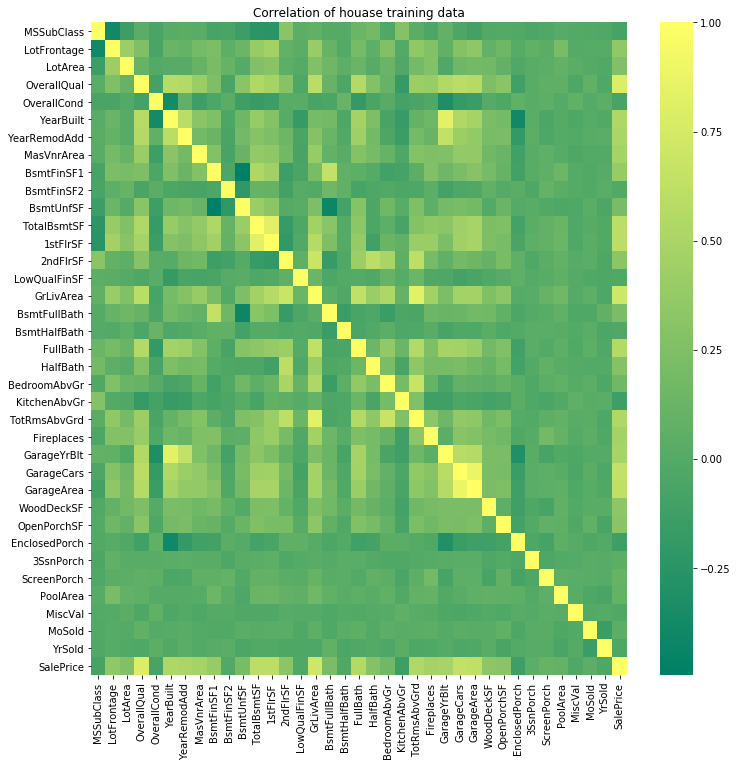

In [3]:
#Ploting the heatmap of correalations of train dataset
plt.figure(figsize = (12,12))
corr = train_df.corr()
sns.heatmap(corr,cmap = plt.cm.summer )
plt.title('Correlation of houase training data')
plt.show()

In [4]:
train_df = train_df.drop(['SalePrice'], axis = 1)
numerical_features = train_df.columns[train_df.dtypes != 'object']
print(f' {len(numerical_features)} Numerical Features:{numerical_features} ')

#Only getting the numerical features in original data
numerical_train_df = train_df[numerical_features]
numerical_train_df = numerical_train_df.fillna(-1)
numerical_train_df.head(5)

 36 Numerical Features:Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object') 


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,548,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,460,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,608,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,642,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,836,192,84,0,0,0,0,0,12,2008


In [5]:
#Select the features whose correlation is > 0.1 or <-0.1 with SalePrice
high_list = list(corr[(corr.SalePrice>0.1) | (corr.SalePrice<-0.1)].index)
high_list.pop(-1)

high_list

['LotFrontage',
 'LotArea',
 'OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'BsmtFullBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 'ScreenPorch']

In [6]:
#Original numerical dataset + LinearRegression
train_x = MinMaxScaler().fit_transform(numerical_train_df)
LR = LinearRegression()
print(cross_val_score(LR,train_x,train_label,cv=5).mean())

0.8499463091778436


In [7]:
#High list dataset + LinearRegression
train_x = MinMaxScaler().fit_transform(numerical_train_df[high_list])
print(cross_val_score(LR,train_x,train_label,cv=5).mean())

0.8288821541594243


In [8]:
#Original numerical dataset + GBR
train_x = MinMaxScaler().fit_transform(numerical_train_df)
GBR = GradientBoostingRegressor()
print(cross_val_score(GBR,train_x,train_label,cv=5).mean())

0.8859551363437852


In [9]:
#High List dataset + GBR
train_x = MinMaxScaler().fit_transform(numerical_train_df[high_list])
print(cross_val_score(GBR,train_x,train_label,cv=5).mean())

0.8743608813656512


In [10]:
from sklearn.linear_model import Lasso
L1_Reg = Lasso(alpha = 0.001)
train_x = MinMaxScaler().fit_transform(numerical_train_df)
L1_Reg.fit(train_x,train_label)
L1_Reg.coef_

array([-0.12408194, -0.        ,  0.        ,  0.81411198,  0.2970946 ,
        0.33007182,  0.08851589,  0.        ,  0.04287006,  0.        ,
       -0.        ,  0.17513694,  0.11086056,  0.        , -0.        ,
        0.87326328,  0.2040765 ,  0.        ,  0.10285172,  0.03174629,
        0.        , -0.        ,  0.12246045,  0.17953898,  0.01851559,
        0.27672243,  0.03230955,  0.09061659,  0.        ,  0.        ,
        0.        ,  0.09550047, -0.        , -0.        ,  0.        ,
       -0.01874705])

In [11]:
L1_mask = list( (L1_Reg.coef_>0) | (L1_Reg.coef_<0) )
numerical_train_df.columns[L1_mask]

Index(['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'BsmtFullBath',
       'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'ScreenPorch', 'YrSold'],
      dtype='object')

In [12]:
from itertools import compress
L1_list = list(compress(list(numerical_train_df),list(L1_mask)))
L1_list

['MSSubClass',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF1',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'BsmtFullBath',
 'FullBath',
 'HalfBath',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'ScreenPorch',
 'YrSold']

In [13]:
#L1_Embedding features + Linear Regression
train_x = MinMaxScaler().fit_transform(numerical_train_df[L1_list])
print(cross_val_score(LR,train_x,train_label,cv=5).mean())

0.8475901403725674


In [14]:
#L1_Embedding features + GBR
print(cross_val_score(GBR,train_x,train_label,cv=5).mean())

0.8841762863802505


# 作業 : (Kaggle)鐵達尼生存預測
https://www.kaggle.com/c/titanic <br />
<br />
## [作業目標]
試著調整特徵篩選的門檻值, 觀察會有什麼影響效果<br />
## [作業重點]
調整相關係數過濾法的篩選門檻, 看看篩選結果的影響 <br />
調整L1 嵌入法篩選門檻, 看看篩選結果的影響 

In [16]:
from sklearn.linear_model import LogisticRegression

train_df = pd.read_csv(data_dir + 'titanic_train.csv')
train_label = train_df.Survived

train_df = train_df.drop(['PassengerId'], axis = 1)
train_df.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


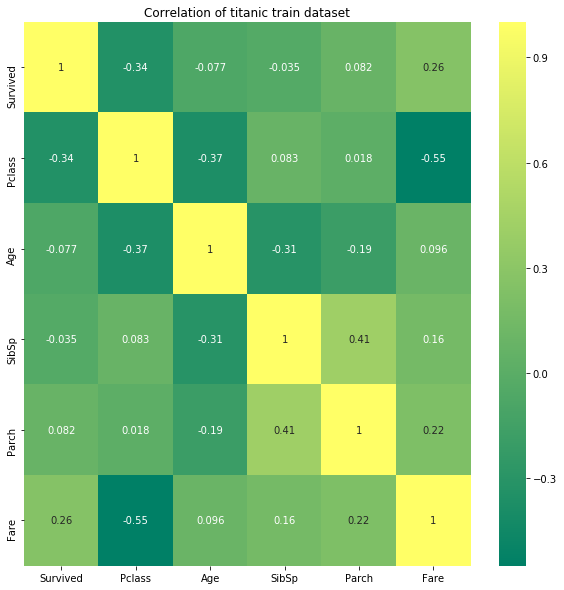

In [17]:
corr = train_df.corr()
plt.figure(figsize = (10,10))
sns.heatmap(corr,cmap = plt.cm.summer, annot = True)
plt.title('Correlation of titanic train dataset')
plt.show()

In [18]:
train_df = train_df.drop(['Survived'], axis = 1)

numerical_features = train_df.columns[train_df.dtypes != 'object']
print(f' {len(numerical_features)} Numerical Features : {numerical_features} ')

df = train_df[numerical_features]
df = df.fillna(-1)
df.head(5)

 5 Numerical Features : Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object') 


,Pclass,Age,SibSp,Parch,Fare
0,3,22.0,1,0,7.2500
1,1,38.0,1,0,71.2833
2,3,26.0,0,0,7.9250
3,1,35.0,1,0,53.1000
4,3,35.0,0,0,8.0500


## 作業1
鐵達尼生存率預測中，試著變更兩種以上的相關係數門檻值，觀察預測能力是否提升?

In [19]:
#original numerical dataset + LogisticRegression
train_x = MinMaxScaler().fit_transform(df)
LR = LogisticRegression()
cross_val_score(LR,train_x,train_label,cv=5).mean()

0.7038635542329971

In [34]:
high_corr_list = list(corr[(corr.Survived > 0.1) | (corr.Survived < -0.1)].index)
high_corr_list.pop(0)
high_corr_list

['Pclass', 'Fare']

In [35]:
#High correlation features ( threshold +/- 0.1 )+ LogisticRegression 
train_x = MinMaxScaler().fit_transform(df[high_corr_list])
cross_val_score(LR,train_x,train_label,cv=5).mean()

0.6791567235397566

In [37]:
high_corr_list = list(corr[(corr.Survived > 0.05) | (corr.Survived < -0.05)].index)
high_corr_list.pop(0)
high_corr_list

['Pclass', 'Age', 'Parch', 'Fare']

In [38]:
#High correlation features (threshold +/- 0.05) + LogisticRegression
train_x = MinMaxScaler().fit_transform(df[high_corr_list])
cross_val_score(LR,train_x,train_label,cv=5).mean()

0.7049872206659582

## 作業2
續上題，使用 L1 Embedding 做特徵選擇(自訂門檻)，觀察預測能力是否提升?

In [39]:
L1_Reg = Lasso(alpha = 0.001)
train_x = MinMaxScaler().fit_transform(df)
L1_Reg.fit(train_x,train_label)
L1_Reg.coef_

array([-0.39684291, -0.25338753, -0.19144856,  0.28161304,  0.28188094])

In [43]:
L1_mask = list((L1_Reg.coef_ > 0.2) | ( L1_Reg.coef_ < -0.2))
df.columns[L1_mask]

Index(['Pclass', 'Age', 'Parch', 'Fare'], dtype='object')

In [44]:
L1_list = list(compress(list(df),list(L1_mask)))
L1_list

['Pclass', 'Age', 'Parch', 'Fare']

In [45]:
#L1 Embedding (threshold +/- 0.2) + LogisticRegression
train_x = MinMaxScaler().fit_transform(df[L1_list])
cross_val_score(LR,train_x,train_label,cv=5).mean()

0.7049872206659582

In [48]:
L1_mask = list((L1_Reg.coef_ > 0.26) | (L1_Reg.coef_ < -0.26))
L1_list = df.columns[L1_mask]
L1_list

Index(['Pclass', 'Parch', 'Fare'], dtype='object')

In [49]:
#L1 Embedding (threshold +/- 0.26) + LogisticRegression
train_x = MinMaxScaler().fit_transform(df[L1_list])
cross_val_score(LR,train_x,train_label,cv=5).mean()

0.6836511764895717